In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.5f}'.format
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import os
import unidecode
import matplotlib.pyplot as plt
from pdpbox import pdp, info_plots, get_dataset
import shap
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc, r2_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from cycler import cycler
import gc
warnings.simplefilter(action='ignore')
pd.options.display.max_rows = 40
pd.set_option('display.max_columns', 200)

In [2]:
def compute_ks(y_test, y_pred_test):
    return stats.ks_2samp(y_pred_test[y_test == 1.0],y_pred_test[y_test == 0.0])[0]

## 1. Load Data

In [3]:
df = pd.read_csv("../data/interim/out6.csv")

In [4]:
df.columns

Index(['ClientId', 'EVER60', 'M0', 'VALUE_ACCOUNT_CREDIT_INFLOW',
       'VALUE_NOT_CATEGORIZED_INFLOW', 'VALUE_INVOICE_PAYMENT_INFLOW',
       'VALUE_INSTALLMENT_PAYMENT_INFLOW', 'VALUE_GIFTS_INFLOW',
       'VALUE_RECEIPTS_INFLOW', 'VALUE_SUBSCRIPTIONS_SERVICES_OUTFLOW',
       'VALUE_BARS_RESTAURANTS_OUTFLOW', 'VALUE_PERSONAL_CARE_OUTFLOW',
       'VALUE_SEND_OUTFLOW', 'VALUE_RECREATION_OUTFLOW',
       'VALUE_MARKETPLACE_OUTFLOW', 'VALUE_HOME_RENT_OUTFLOW',
       'VALUE_NOT_CATEGORIZED_OUTFLOW', 'VALUE_OTHERS_OUTFLOW',
       'VALUE_INVOICE_PAYMENT_OUTFLOW', 'VALUE_HEALTH_OUTFLOW',
       'VALUE_TRANSPORTATION', 'VALUE_CLOTHES_OUTFLOW',
       'PARCELING_REMAINING_VALUE', 'PARCELING_COUNT_NOT_PAID_YET',
       'VALUE_PRODUCT_CARD_OUTFLOW', 'VALUE_PRODUCT_CREDIT_CARD_OUTFLOW',
       'VALUE_PRODUCT_TAXES_OUTFLOW', 'VALUE_PRODUCT_OBJECTIVES_OUTFLOW',
       'VALUE_PRODUCT_OTHERS_OUTFLOW', 'VALUE_PRODUCT_BILLET_INFLOW',
       'VALUE_PRODUCT_CREDIT_CARD_INFLOW', 'VALUE_PRODUCT_OBJECT

In [5]:
columns_to_drop = ['SKProductFirstTransaction', 
                        'Platform', 
                        'Device', 
                        'InstallSource',
                        'AddressState',
                        'FlagInvitedUser']
df.drop(columns = columns_to_drop, inplace = True)

## 2. Treino e Validacao

In [6]:
df['M0'] = pd.to_datetime(df['M0'])

In [7]:
df['M0'].max()

Timestamp('2019-09-27 00:00:00')

In [8]:
group = df.groupby(['M0']).agg({'EVER60':['count', 'sum']}).reset_index()

In [9]:
group.columns = group.columns.droplevel()

In [10]:
group['bad'] = group['sum']/group['count']

In [11]:
group

count   sum     bad
0  2019-05-03  17302  2275 0.13149
1  2019-05-10  17262  2358 0.13660
2  2019-05-17  17202  2379 0.13830
3  2019-05-24  17084  2403 0.14066
4  2019-05-31  17027  2311 0.13573
5  2019-06-07  26625  3716 0.13957
6  2019-06-14  26393  3673 0.13917
7  2019-06-21  26306  3524 0.13396
8  2019-06-28  26167  3553 0.13578
9  2019-07-05  30301  4098 0.13524
10 2019-07-12  30228  4107 0.13587
11 2019-07-19  30031  4237 0.14109
12 2019-07-26  29908  4160 0.13909
13 2019-08-02  26866  3617 0.13463
14 2019-08-09  26841  3732 0.13904
15 2019-08-16  26661  3611 0.13544
16 2019-08-23  26579  3732 0.14041
17 2019-08-30  26510  3687 0.13908
18 2019-09-06  38882  5458 0.14037
19 2019-09-13  38402  5007 0.13038
20 2019-09-20  38395  5314 0.13840
21 2019-09-27  38266  5398 0.14107

In [12]:
df_val = df[df['M0']>='2019-08-01'].copy()
df_train = df[df['M0']<='2019-07-26']

In [13]:
df_val['M0'].max(), df_val['M0'].min()

(Timestamp('2019-09-27 00:00:00'), Timestamp('2019-08-02 00:00:00'))

In [14]:
df_train['ClientId'].count(), df_val['ClientId'].count() 

(311836, 287402)

#### Ajustes

In [15]:
df_val.rename(columns = {'EVER60': 'target'}, inplace = True)
df_train.rename(columns = {'EVER60': 'target'}, inplace = True)

X_train_M0s = df_train['M0']
X_train_ids = df_train['ClientId']
X_train = df_train.drop(columns = ['M0','ClientId', 'target'])
y_train = df_train['target']

X_val_M0s = df_val['M0']
X_val_ids = df_val['ClientId']
X_val = df_val.drop(columns = ['M0','ClientId', 'target'])
y_val = df_val['target']

# y_val_full = y_val.copy()
# y_val = y_val.loc[~X_val.ClientId.isin(X_train.ClientId)]
# X_val_full = X_val.copy()
# X_val = X_val.loc[~X_val.ClientId.isin(X_train.ClientId)]

## 3. Train Model

#### Logistic Regression

In [16]:
logreg = LogisticRegression(C=15, random_state=42, class_weight='balanced', penalty='l2')
mdl = logreg.fit(X_train, y_train)
print(mdl)

LogisticRegression(C=15, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [17]:
y_train_pred= logreg.predict(X_train)
y_train_pred_proba= logreg.predict_proba(X_train)[:, 1] 

acc_train = accuracy_score(y_train, y_train_pred)

sample0_train = y_train_pred[y_train == 0]
sample_train = y_train_pred[y_train == 1 ]

ks_train_logreg = compute_ks(y_train, y_train_pred_proba)

roc_train_logreg = roc_auc_score(y_train, y_train_pred)


print('sklearn:')
print("Accuracy-train is %s"%(acc_train))
print("KS-train is:", compute_ks(y_train, y_train_pred_proba))

sklearn:
Accuracy-train is 0.8288940340435357
KS-train is: 0.5973486201338634


In [18]:
y_val_pred= logreg.predict(X_val)
y_val_pred_proba= logreg.predict_proba(X_val)[:, 1] 

acc_val = accuracy_score(y_val, y_val_pred)

sample0_val = y_val_pred[y_val == 0]
sample_val = y_val_pred[y_val == 1 ]

ks_val_logreg = compute_ks(y_val, y_val_pred_proba)
roc_val_logreg = roc_auc_score(y_val, y_val_pred_proba)

print('sklearn:')
print("Accuracy-val is %s"%(acc_val))
print("KS-val is:", compute_ks(y_val, y_val_pred_proba))

sklearn:
Accuracy-val is 0.8377151168050326
KS-val is: 0.4592059373061789


In [19]:
metrics_logreg = pd.DataFrame({'Modelo':['LogReg'],
                         'ROC_treino': roc_train_logreg,
                         'ROC_val': roc_val_logreg,
                         'KS_treino': ks_train_logreg,
                         'KS_val': ks_val_logreg})
metrics_logreg

Modelo  ROC_treino  ROC_val  KS_treino  KS_val
0  LogReg     0.79305  0.75157    0.59735 0.45921

#### LightGBM

In [20]:
import lightgbm as lgb

train_data=lgb.Dataset(X_train,label=y_train)
valid_data=lgb.Dataset(X_val,label=y_val)

params = {
        'metric' : 'auc',
        'boosting_type' : 'gbdt',
        'colsample_bytree' : 0.6,
        'num_leaves' : 15,
        'max_depth' : -1,
        'n_estimators' : 1000,
        'min_data_in_leaf':80, 
        'reg_alpha': 20,
        'reg_lambda': 20,
        #'is_unbalance':True,
        'objective':'binary',
        #'learning_rate':0.1
        'seed': 42
    }


lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=[train_data,valid_data],
                 early_stopping_rounds= 10,
                 verbose_eval= 10
                 )


Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.883664	valid_1's auc: 0.835927
[20]	training's auc: 0.890196	valid_1's auc: 0.842587
[30]	training's auc: 0.893902	valid_1's auc: 0.846241
[40]	training's auc: 0.896647	valid_1's auc: 0.85083
[50]	training's auc: 0.898629	valid_1's auc: 0.852947
[60]	training's auc: 0.900248	valid_1's auc: 0.854232
[70]	training's auc: 0.901459	valid_1's auc: 0.855233
[80]	training's auc: 0.902346	valid_1's auc: 0.855991
[90]	training's auc: 0.903126	valid_1's auc: 0.856523
[100]	training's auc: 0.903883	valid_1's auc: 0.856616
[110]	training's auc: 0.904544	valid_1's auc: 0.856596
Early stopping, best iteration is:
[107]	training's auc: 0.904375	valid_1's auc: 0.856701


In [21]:
print(y_val.mean(),y_train.mean())
print(lgbm.predict(X_val).mean(),lgbm.predict(X_train).mean())

0.13763300185802466 0.1372323913852153
0.09538724316528234 0.13721819898701718


In [22]:
lgbm_val = pd.DataFrame({'real':y_val,'pred':lgbm.predict(X_val),'1-pred':1-lgbm.predict(X_val)})
lgbm_train = pd.DataFrame({'real':y_train,'pred':lgbm.predict(X_train),'1-pred':1-lgbm.predict(X_train)})
lgbm_all = lgbm_val.append(lgbm_train, ignore_index=True)


metrics_lgbm = pd.DataFrame({'Modelo':['LightGBM'],
                         'ROC_treino': [roc_auc_score(lgbm_train['real'], (lgbm_train['pred']))],
                         'ROC_val': roc_auc_score(lgbm_val['real'], (lgbm_val['pred'])),
                         'KS_treino': stats.ks_2samp(lgbm_train[lgbm_train['real'] == 0]['pred'], lgbm_train[lgbm_train['real'] == 1]['pred']).statistic,
                         'KS_val': [stats.ks_2samp(lgbm_val[lgbm_val['real'] == 0]['pred'], lgbm_val[lgbm_val['real'] == 1]['pred']).statistic]})
metrics_lgbm

Modelo  ROC_treino  ROC_val  KS_treino  KS_val
0  LightGBM     0.90437  0.85670    0.65424 0.54612

In [23]:
metrics = pd.concat([metrics_lgbm, metrics_logreg])

In [24]:
metrics

Modelo  ROC_treino  ROC_val  KS_treino  KS_val
0  LightGBM     0.90437  0.85670    0.65424 0.54612
0    LogReg     0.79305  0.75157    0.59735 0.45921

## 4. Scores

In [25]:
reglog_train = pd.DataFrame({'ClientId': X_train_ids,
                             'M0': X_train_M0s,
                             'real':y_train,
                            'pred': y_train_pred_proba, 
                            '1-pred': 1-y_train_pred_proba})


reglog_val = pd.DataFrame({'ClientId': X_val_ids,
                           'M0': X_val_M0s,
                           'real':y_val,
                            'pred': y_val_pred_proba, 
                            '1-pred': y_val_pred_proba})

reglog_all = pd.concat([reglog_train, reglog_val])

In [26]:
lgbm_val = pd.DataFrame({'ClientId': X_val_ids,
                         'M0': X_val_M0s,
                         'real':y_val,
                         'pred':lgbm.predict(X_val),
                         '1-pred':1-lgbm.predict(X_val)})

lgbm_train = pd.DataFrame({'ClientId': X_train_ids,
                           'M0': X_train_M0s,
                           'real':y_train,
                           'pred':lgbm.predict(X_train),
                           '1-pred':1-lgbm.predict(X_train)})

lgbm_all = pd.concat([lgbm_train, lgbm_val])

In [27]:
lgbm_all.to_csv('lgm_all_scores.csv', index = False)
reglog_all.to_csv('reglog_all_scores.csv', index = False)

## 5. KS ao longo das safras

In [28]:
def metrics_M0ly(df):
    ks=[]
    roc = []
    M0 = []
    for i in df['M0'].unique():
        df_temp = df.loc[df.M0==i]
        ks.append(stats.ks_2samp(df_temp[df_temp['real'] == 0]['pred'], df_temp[df_temp['real'] == 1]['pred']).statistic)
        roc.append(roc_auc_score(df_temp['real'], (df_temp['pred'])))
    
    return pd.DataFrame({'M0':df['M0'].unique(),'ks':ks,'roc':roc})

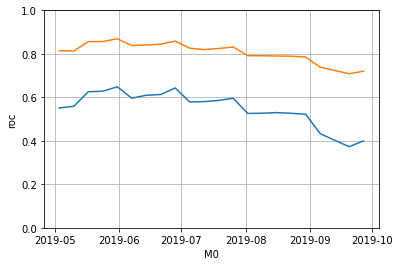

In [29]:
plot_metrics = metrics_M0ly(reglog_all)
ax = sns.lineplot(x="M0", y="ks",data=plot_metrics) 
ax2 = sns.lineplot(x="M0", y="roc",data=plot_metrics) 
ax2.set_ylim([0, 1])
plt.grid()

In [30]:
plot_metrics

M0      ks     roc
0  2019-05-03 0.55118 0.81440
1  2019-05-24 0.62825 0.85663
2  2019-05-17 0.62588 0.85620
3  2019-05-31 0.64845 0.86941
4  2019-05-10 0.55863 0.81270
5  2019-06-07 0.59616 0.83848
6  2019-06-14 0.60971 0.84061
7  2019-06-21 0.61292 0.84434
8  2019-06-28 0.64319 0.85846
9  2019-07-12 0.58035 0.81965
10 2019-07-26 0.59570 0.83154
11 2019-07-05 0.57877 0.82597
12 2019-07-19 0.58589 0.82461
13 2019-08-30 0.52237 0.78541
14 2019-08-23 0.52652 0.78916
15 2019-08-16 0.52972 0.78996
16 2019-08-02 0.52598 0.79149
17 2019-08-09 0.52690 0.79136
18 2019-09-20 0.37322 0.70848
19 2019-09-13 0.40259 0.72370
20 2019-09-27 0.39984 0.72041
21 2019-09-06 0.43298 0.73861

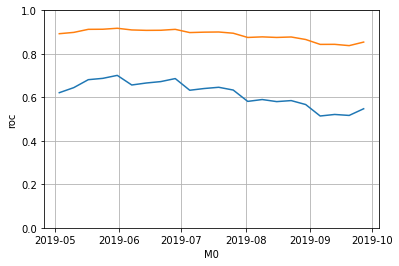

In [31]:
plot_metrics = metrics_M0ly(lgbm_all)
ax = sns.lineplot(x="M0", y="ks",data=plot_metrics) 
ax2 = sns.lineplot(x="M0", y="roc",data=plot_metrics) 
ax2.set_ylim([0, 1])
plt.grid()

In [32]:
plot_metrics

M0      ks     roc
0  2019-05-03 0.62134 0.89264
1  2019-05-24 0.68729 0.91317
2  2019-05-17 0.68120 0.91273
3  2019-05-31 0.70098 0.91763
4  2019-05-10 0.64468 0.89868
5  2019-06-07 0.65679 0.90993
6  2019-06-14 0.66590 0.90803
7  2019-06-21 0.67238 0.90843
8  2019-06-28 0.68629 0.91266
9  2019-07-12 0.64059 0.89975
10 2019-07-26 0.63355 0.89488
11 2019-07-05 0.63258 0.89786
12 2019-07-19 0.64624 0.90049
13 2019-08-30 0.56689 0.86599
14 2019-08-23 0.58504 0.87755
15 2019-08-16 0.58033 0.87545
16 2019-08-02 0.58136 0.87539
17 2019-08-09 0.58989 0.87806
18 2019-09-20 0.51677 0.83778
19 2019-09-13 0.52124 0.84373
20 2019-09-27 0.54750 0.85411
21 2019-09-06 0.51416 0.84350

## 5. Feature Importance e Coeficientes

### Logistic Regression

In [33]:
feature_importance = abs(logreg.coef_[0])

In [34]:
import numpy as np
coefs = abs(logreg.coef_[0])
coefs = 100.0 * (feature_importance / feature_importance.max())
top = np.argpartition(coefs, -30)[-30:]
top_sorted=top[np.argsort(coefs[top])]
print(X_train.columns[top_sorted])

Index(['VALUE_PERSONAL_CARE_OUTFLOW', 'VALUE_OTHERS_OUTFLOW',
       'VALUE_CLOTHES_OUTFLOW', 'VALUE_INSTALLMENT_PAYMENT_INFLOW',
       'VALUE_HOME_RENT_OUTFLOW', 'VALUE_HEALTH_OUTFLOW',
       'VALUE_BARS_RESTAURANTS_OUTFLOW', 'VALUE_SEND_OUTFLOW',
       'VALUE_PRODUCT_CARD_OUTFLOW', 'VALUE_PRODUCT_OBJECTIVES_OUTFLOW',
       'VALUE_PRODUCT_OBJECTIVES_INFLOW', 'VALUE_NOT_CATEGORIZED_INFLOW',
       'VALUE_PRODUCT_CREDIT_CARD_INFLOW', 'COUNT_INSTALLMENT_PAYMENT',
       'VALUE_ACCOUNT_CREDIT_INFLOW', 'VALUE_PRODUCT_BILLET_INFLOW',
       'SALDO_CRED_DISP_M_3', 'VALUE_MARKETPLACE_OUTFLOW',
       'VALUE_NOT_CATEGORIZED_OUTFLOW', 'VALUE_RECEIPTS_INFLOW',
       'VALUE_SUBSCRIPTIONS_SERVICES_OUTFLOW',
       'VALUE_PRODUCT_CREDIT_CARD_OUTFLOW', 'VALUE_PRODUCT_OTHERS_OUTFLOW',
       'VALUE_INVOICE_PAYMENT_OUTFLOW', 'Renda', 'SALDO_CRED_DISP_M_2',
       'PARCELING_REMAINING_VALUE', 'VALUE_INVOICE_PAYMENT_INFLOW',
       'VALUE_PRODUCT_INVOICE_INFLOW', 'SALDO_CRED_DISP_M_1'],
      dtype

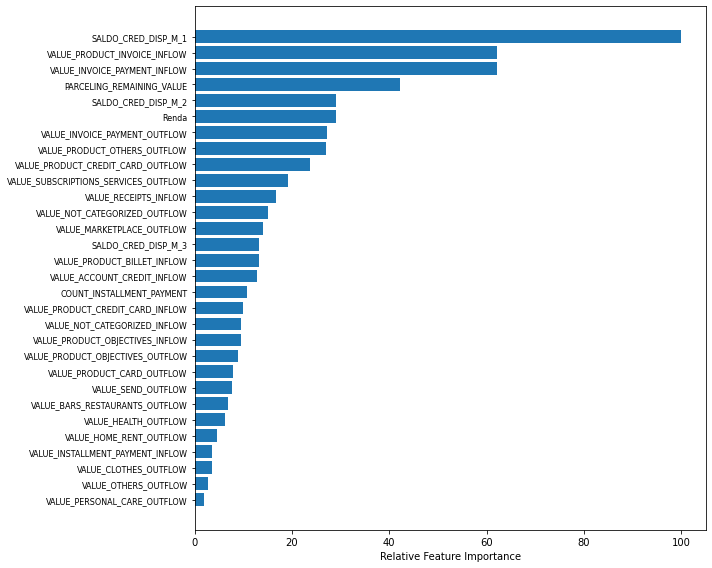

In [35]:
sorted_idx = top_sorted
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, coefs[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()



In [ ]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train, plot_type='dot')

## 6. GHs

In [ ]:
def GH_table(pred,y,gh,podar_limites=False):
    # gh = quantidade de grupos desejado 
    # podar_limite = trazer corte minimo da predição para 0 e maximo para 1
    df = pd.DataFrame({'real':y,'pred':pred})
    #Criar GH
    q = 1
    passo = 1/gh
    df['GH']=0
    for i in range(gh):
        maxi = df['pred'].quantile(q)+0.00000001
        mini = df['pred'].quantile(q-passo)
        df['GH'][((df['pred'] < maxi) & (df['pred']>=mini))] = (gh-i)
        q = round((1 -(1+i)*passo),7)
    df['GH'][df['GH']==0]=1
    
    #agrupar dados por GH
    df = df.groupby('GH').agg({'real':['count','sum'],'pred':['max','min','mean']})
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()
    
    #Criar colunas
    df['%_freq'] = round(df['real_count']/df['real_count'].sum(),4)
    df['%_taxa_target_1'] = df['real_sum']/df['real_count']
    df['#_target_0'] = df['real_count']-df['real_sum']
    df['ODDS'] = df['real_sum']/(df['#_target_0'])
    df['pred_min'] =df['pred_max'].shift(1)
    #renomear
    df.rename(columns={'real_count':'#_freq','real_sum':'#_target_1',
                       'pred_max':'limite_pred_superior','pred_min':'limite_pred_inferior',
                       'pred_mean':'pred_media_modelo'},inplace=True)
    
    #ordenar
    df = df[['GH', '#_freq', '%_freq', '#_target_1', '#_target_0', 'limite_pred_superior',
       'limite_pred_inferior', 'pred_media_modelo',
       '%_taxa_target_1', 'ODDS']]
    
    #podar limites (opcional)
    if podar_limites==True:
        df['limite_pred_inferior'][df.limite_pred_inferior.isna()]=-0.2
        df['limite_pred_superior'][df.limite_pred_superior==df.limite_pred_superior.max()]=1.2
        
    df['%_cum_0'] = df['#_target_0'].cumsum() / df['#_target_0'].sum()
    df['%_cum_1'] = df['#_target_1'].cumsum() / df['#_target_1'].sum()
    df['ks'] = df['%_cum_0']-df['%_cum_1']
    
    df = df.drop('pred_media_modelo',1)
    
    return df

def GH_table_tratado(pred,y,gh,podar_limites=False):
    # gh = quantidade de grupos desejado 
    # podar_limite = trazer corte minimo da predição para 0 e maximo para 1
    df = pd.DataFrame({'real':y,'pred':pred})
    #Criar GH
    df['GH']=0
    for i in range(len(gh)):
        df['GH'][((df['pred'] < gh.loc[i,'limite_pred_superior']) & (df['pred']>=gh.loc[i,'limite_pred_inferior']))] = (gh.loc[i,'GH'])

    
    #agrupar dados por GH
    df = df.groupby('GH').agg({'real':['count','sum'],'pred':['max','min','mean']})
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df = df.reset_index()
    
    #Criar colunas
    df['%_freq'] = round(df['real_count']/df['real_count'].sum(),4)
    df['%_taxa_target_1'] = df['real_sum']/df['real_count']
    df['#_target_0'] = df['real_count']-df['real_sum']
    df['ODDS'] = df['real_sum']/(df['#_target_0'])
    df['pred_min'] =df['pred_max'].shift(1)
    #renomear
    df.rename(columns={'real_count':'#_freq','real_sum':'#_target_1',
                       'pred_max':'limite_pred_superior','pred_min':'limite_pred_inferior',
                       'pred_mean':'pred_media_modelo'},inplace=True)
    
    #ordenar
    df = df[['GH', '#_freq', '%_freq', '#_target_1', '#_target_0', 'limite_pred_superior',
       'limite_pred_inferior', 'pred_media_modelo',
       '%_taxa_target_1', 'ODDS']]
    
    #podar limites (opcional)
    if podar_limites==True:
        df['limite_pred_inferior'][df.limite_pred_inferior.isna()]=-0.2
        df['limite_pred_superior'][df.limite_pred_superior==df.limite_pred_superior.max()]=1.2
        
    df['%_cum_0'] = df['#_target_0'].cumsum() / df['#_target_0'].sum()
    df['%_cum_1'] = df['#_target_1'].cumsum() / df['#_target_1'].sum()
    df['ks'] = df['%_cum_0']-df['%_cum_1']
    
    df = df.drop('pred_media_modelo',1)
    
    return df

def plot_GH(pred,y,date,GH_params):
    df = pd.DataFrame({'pred':pred,'real':y,'date':date})
    df['GH']=0
    for i in range(len(GH_params)):
        df.loc[(df.pred>GH_params.limite_pred_inferior[i])&(df.pred<=GH_params.limite_pred_superior[i]),'GH']=GH_params.GH[i]
    df = df.groupby(['GH','date'])['real'].mean().reset_index()
    df = df[df['GH'].isin([1,2,3,4,5])]
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    ax = sns.lineplot(x="date", y="real", hue="GH",data=df)
#     df_ghs_safras.sort_index().plot(figsize=(14, 8), marker='o', grid =True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return df

In [ ]:
# GH = GH_table(reglog_train['pred'],reglog_train['real'],30,True)
# GH

In [ ]:
# GH = GH_table(lgbm_train['pred'],lgbm_train['real'],20,True)
# GH

In [ ]:
# GH = pd.DataFrame({'GH':[1,2,3,4,5,6,7,8, 9, 10, 11, 12,],
#                    'limite_pred_inferior':[-0.2,0.01915,0.02579,0.03657,0.04803,0.06913,0.08789,0.11498,0.16205,0.25029,0.45988,0.77019],
                   
#                    'limite_pred_superior':[0.01915,0.02579,0.03657,0.04803,0.06913,0.08789,0.11498,0.16205,0.25029,0.45988,0.77019,1.20000],
#                   })

In [ ]:
# lgbm_train.columns

In [ ]:
# plot_GH(lgbm_train['pred'],lgbm_train['real'],lgbm_train['M0'],GH)

In [ ]:
# plot_GH(lgbm_all['pred'],lgbm_all['real'],lgbm_all['M0'],GH)

In [ ]:
# GH = pd.DataFrame({'GH':[1,2,3,4,5,6,7],
#                    'limite_pred_inferior':[-0.2, 0.01915, 0.02579, 0.03657, 0.04803, 0.10, 0.188031],
#                    'limite_pred_superior':[0.01915, 0.02579, 0.03657, 0.04803, 0.10, 0.188031, 1.200000]})

GH = pd.DataFrame({'GH':[1,2,3,4,5,6,7],
                   'limite_pred_inferior':[-0.2, 0.01915, 0.02579, 0.03657, 0.04803, 0.10, 0.188031],
                   'limite_pred_superior':[0.01915, 0.02579, 0.03657, 0.04803, 0.10, 0.188031, 1.200000]})

In [ ]:
GH.head()

In [ ]:
plot_GH(lgbm_all['pred'],lgbm_all['real'],lgbm_all['M0'],GH)
# ax.set_ylim([0,0.1])

In [ ]:
table1 = GH_table_tratado(lgbm_train['pred'],lgbm_train['real'],GH,True)

In [ ]:
table1[['GH', '%_taxa_target_1', '%_freq']]

In [ ]:
table1[['GH', '%_taxa_target_1', '%_freq']].T.to_excel('distribuicao_ghs_agrupados.xlsx')

In [ ]:
table1.to_excel('../Reports/Model/distribuicao_ghs_agrupados.xlsx')

### Volumetria GHs

In [ ]:
from cycler import cycler
import numpy as np
import matplotlib.pyplot as plt

def plot_GH_vol(pred,y,date,GH_params):
    df = pd.DataFrame({'pred':pred,'Proporção_GH':y,'date':date})
    df['GH']=0
    for i in range(len(GH_params)):
        df.loc[(df.pred>GH_params.limite_pred_inferior[i])&(df.pred<=GH_params.limite_pred_superior[i]),'GH']=GH_params.GH[i]

    df = df.groupby(['GH','date'])['Proporção_GH'].count()
    df = df.groupby(level=1).apply(lambda x: x / float(x.sum()))
    df = df.reset_index().pivot(index='date', columns='GH').reset_index()
    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]
    
    degList = [i for i in df.columns if i[0:4]=='Prop']
    bar_l = range(df.shape[0])
    
    cm = plt.get_cmap('plasma')
    #cor neon = 'winter'
    #rainbow_r
    #Spectral
    f, ax = plt.subplots(1, figsize=(10,5))
    ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

    bottom = np.zeros_like(bar_l).astype('float')
    for i, deg in enumerate(degList):
        ax.bar(bar_l, df[deg], bottom = bottom, label=deg)
        bottom += df[deg].values
    
    
    dates_labels = ['03/05', '10/05', '17/05', '24/05', '31/05',
                   '07/06', '14/06', '21/06', '28/06',
                   '05/07', '12/07', '19/07', '26/07',
                   '02/08', '09/08', '16/08', '23/08', '30/08',
                   '06/09', '13/09', '20/09', '27/09']  
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.1f}'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center', color ='white')
    
    ax.set_xticks(bar_l)
    ax.set_xticklabels(dates_labels, rotation=90, size='large')
    ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=2, fontsize='large')
    f.subplots_adjust(right=0.75, bottom=0.4)
    f.set_size_inches(18.5, 10.5, forward=True)
    f.show()
    
    return df

In [ ]:
lgbm_all['M0']=pd.to_datetime(lgbm_all['M0'])
lgbm_all['M0']=lgbm_all['M0'].dt.date
table2 = plot_GH_vol(lgbm_all['pred'],lgbm_all['real'],lgbm_all['M0'],GH)

In [ ]:
table2.to_excel('../Reports/Model/estabilidade_%_GHs.xlsx')